In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical 
#from keras_tqdm import TQDMNotebookCallback
#
from tensorflow.keras.models import load_model
import h5py

# dont know if i need these
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [2]:
# read in data
df = pd.read_csv("avocado_2020.csv")
df['date'] = pd.to_datetime(df['date'])
s=(['date'])


# splitt
df_conv = df[df.type == 'conventional']
df_org = df[df.type == 'organic']


# mean values
conv_mean = df_conv.groupby('date').mean()
org_mean = df_conv.groupby('date').mean()

(0, 3.5)

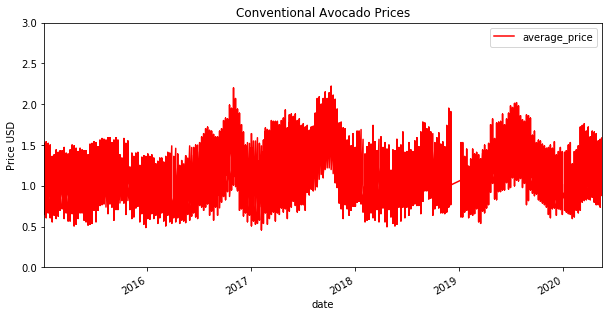

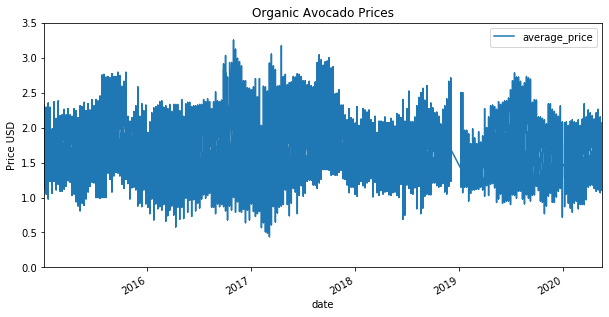

In [3]:
plt = df_conv.plot('date','average_price', title = 'Conventional Avocado Prices' , color = 'red', figsize=(10,5))
plt.set_ylabel('Price USD')
plt.set_ylim(0,3)

plt_2 = df_org.plot('date','average_price', title = 'Organic Avocado Prices', figsize = (10,5))
plt_2.set_ylabel('Price USD')
plt_2.set_ylim(0,3.5)


### Scale data

In [5]:
conv_t = conv_mean[:'2018'].iloc[:,0:1].values
conv_v = conv_mean['2018':].iloc[:,0:1].values
data = conv_mean.iloc[:,0:1].values

print('We use 278 time points and ', round(len(conv_t) / len(data),2), 'percent of the data for training')
nr_trainingpoints = len(conv_t)

sc = MinMaxScaler(feature_range=(0,1))
conv_scaled = sc.fit_transform(data)


# We use the 60 last points as x of t
nr = 60
X_train = []
y_train = []

X_test = []
y_test = []


for i in range(nr,len(data)):
    if (i < nr_trainingpoints):
        X_train.append(conv_scaled[i-nr:i,0])
        y_train.append(conv_scaled[i,0])
        
    X_test.append(conv_scaled[i-nr:i,0])
    y_test.append(conv_scaled[i,0])
    
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train),  np.array(X_test) , np.array(y_test)
 
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

We use 278 time points and  0.74 percent of the data for training


### Weights for the validation data

In [6]:
val_samples = int((len(y_test)-len(y_train))/2)
val_sample_weights = np.zeros(len(X_test))

for i in range(len(y_train),len(y_train) + val_samples):
    val_sample_weights[i] = 1

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape,val_samples)

(146, 60, 1) (146,) (218, 60, 1) (218,) 36


In [7]:
test_samples = int((len(y_test)-len(y_train))/2)
test_sample_weights = np.zeros(len(X_test))

for i in range(len(y_train)+test_samples,len(y_test)):
    test_sample_weights[i] = 1
  

In [6]:
# here i make my own metric but i dont use it
import keras.backend as b
def squard_error(y_true, y_pred):
    return b.sum(b.square(y_pred - y_true))

### LSTM with 4 layers

In [19]:
epochs = 1000
units = 50
dropout = 0.2

lstm = Sequential()

# First
lstm.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm.add(Dropout(dropout))

# Second
lstm.add(LSTM(units=units, return_sequences=True))
lstm.add(Dropout(dropout))

# Third
lstm.add(LSTM(units=units, return_sequences=True))
lstm.add(Dropout(dropout))

# Fourth 
lstm.add(LSTM(units=units))
lstm.add(Dropout(dropout))

# Output
lstm.add(Dense(units=1))

# 
#lstm.compile(optimizer='rmsprop',loss='mean_squared_error')
#hist = lstm.fit(X_train,y_train, validation_data = (X_test,y_test,val_sample_weights), epochs=epochs, batch_size=32, verbose = 0)

### Gated Recurrent Unit

In [21]:
epochs_gru = 1000
units = 50
dropout = 0.2

gru = Sequential()

# First
gru.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1],1)))
gru.add(Dropout(dropout))

# Second
gru.add(GRU(units=units, return_sequences=True))
gru.add(Dropout(dropout))

# Third
gru.add(GRU(units=units, return_sequences=True))
gru.add(Dropout(dropout))

# Fourth 
gru.add(GRU(units=units))
gru.add(Dropout(dropout))

# Output - regresstion has one output unit
gru.add(Dense(units=1))

# Use default optimization values
gru.compile(optimizer='rmsprop',loss='mean_squared_error')
hist_gru = gru.fit(X_train,y_train, validation_data = (X_test,y_test,val_sample_weights), epochs=epochs_gru, batch_size=32, verbose = 0)

### Simple RNN

In [10]:
epochs_rnn = 1000
units = 50
dropout = 0.2

rnn = Sequential()

# First
rnn.add(SimpleRNN(units=units, return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn.add(Dropout(dropout))

# Second
rnn.add(SimpleRNN(units=units, return_sequences=True))
rnn.add(Dropout(dropout))

# Third
rnn.add(SimpleRNN(units=units, return_sequences=True))
rnn.add(Dropout(dropout))

# Fourth 
rnn.add(SimpleRNN(units=units))
rnn.add(Dropout(dropout))

# Output - regresstion has one output unit
rnn.add(Dense(units=1))

# Use default optimization values
#rnn.compile(optimizer='rmsprop',loss='mean_squared_error')
#hist_rnn = rnn.fit(X_train,y_train, validation_data = (X_test,y_test,val_sample_weights), epochs=epochs_gru, batch_size=32, verbose = 0)

### Convolutional LSTM 

In [11]:
epochs_conv = 1000
units = 50
dropout = 0.2

conv = Sequential()

# First
conv.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
conv.add(MaxPooling1D(pool_size=2))

# Second
conv.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
conv.add(MaxPooling1D(pool_size=2))

# Third
conv.add(LSTM(units=units, return_sequences=True))
conv.add(Dropout(dropout))

# Fourth 
conv.add(LSTM(units=units))
conv.add(Dropout(dropout))

# Output
conv.add(Dense(units=1))

# 
#conv.compile(optimizer='rmsprop',loss='mean_squared_error')
#hist_conv = conv.fit(X_train,y_train, validation_data = (X_test,y_test,val_sample_weights), epochs=epochs, batch_size=32, verbose = 0)

### Learning curve LSTM

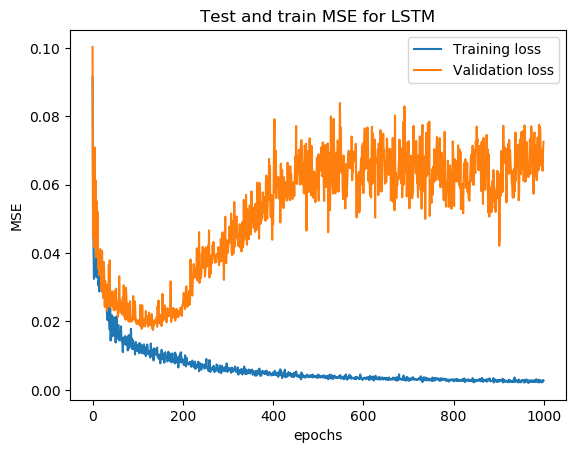

In [20]:
import matplotlib.pyplot as plt

train_loss = hist.history['loss']
val_mse = np.asarray(hist.history['val_loss'])*len(y_test)/val_samples

xc         = range(epochs)

plt.figure()
plt.plot(xc, train_loss, label = 'Training loss')
plt.plot(xc, val_mse, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Test and train MSE for LSTM')
plt.show()


### Learning curve gated recurrent unit

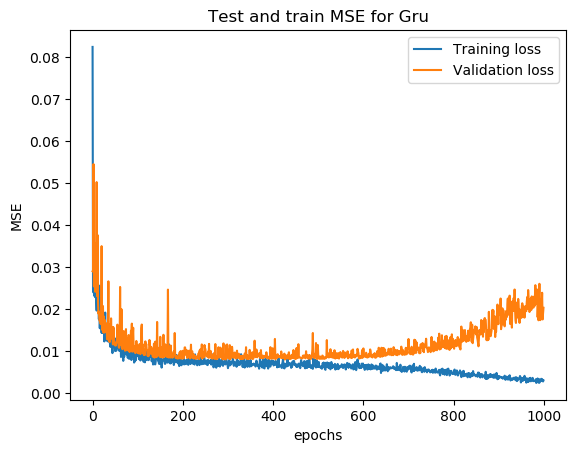

In [21]:
import matplotlib.pyplot as plt

train_loss = hist_gru.history['loss']

val_mse_gru = np.asarray(hist_gru.history['val_loss'])*len(y_test)/val_samples


xc         = range(epochs_gru)
plt.figure()
plt.plot(xc, train_loss, label = 'Training loss')
plt.plot(xc, val_mse_gru, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Test and train MSE for Gru')
plt.show()

### Recurrent neural network

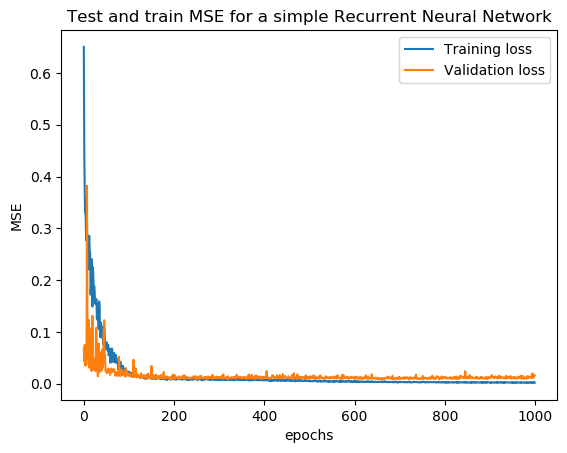

In [22]:
import matplotlib.pyplot as plt

train_loss = hist_rnn.history['loss']

val_mse_rnn = np.asarray(hist_rnn.history['val_loss'])*len(y_test)/val_samples


xc         = range(epochs_rnn)
plt.figure()
plt.plot(xc, train_loss, label = 'Training loss')
plt.plot(xc, val_mse_rnn, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Test and train MSE for a simple Recurrent Neural Network')
plt.show()

### Convolutional LSTM learning curve

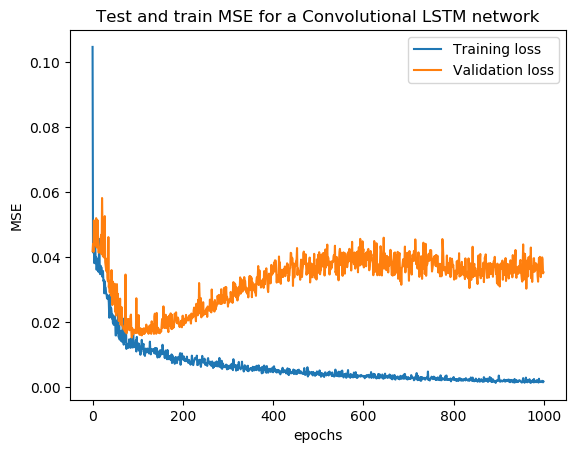

In [23]:
import matplotlib.pyplot as plt

train_loss = hist_conv.history['loss']

val_mse_conv = np.asarray(hist_conv.history['val_loss'])*len(y_test)/val_samples


xc         = range(epochs_conv)
plt.figure()
plt.plot(xc, train_loss, label = 'Training loss')
plt.plot(xc, val_mse_conv, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Test and train MSE for a Convolutional LSTM network')
plt.show()

### Running models for optimal amount

In [13]:

    
epochs_lstm = 134
lstm.compile(optimizer='rmsprop',loss='mean_squared_error')
hist = lstm.fit(X_train,y_train, epochs=epochs_lstm, batch_size=32, verbose = 0) 
best_square_error_lstm = lstm.evaluate(X_test,y_test,sample_weight=test_sample_weights,verbose=0)*len(y_test)/test_samples
print('Best square error for the lstm model: ', round(best_square_error_lstm,5))


epochs_gru = 426
gru.compile(optimizer='rmsprop',loss='mean_squared_error')
hist_gru = gru.fit(X_train,y_train, epochs=epochs_gru, batch_size=32, verbose = 0)
best_square_error_gru = gru.evaluate(X_test,y_test,sample_weight=test_sample_weights,verbose = 0)*len(y_test)/test_samples
print('Best square error for the Gated recurrent unit model: ', round(best_square_error_gru,5))


epochs_rnn = 688
rnn.compile(optimizer='rmsprop',loss='mean_squared_error')
hist_rnn = rnn.fit(X_train,y_train,  epochs=epochs_rnn, batch_size=32, verbose = 0)
best_square_error_rnn = rnn.evaluate(X_test,y_test,sample_weight=test_sample_weights, verbose = 0)*len(y_test)/test_samples
print('Best square error for the Simple RNN: ', round(best_square_error_rnn,5))


epochs_conv = 87
conv.compile(optimizer='rmsprop',loss='mean_squared_error')
hist_conv = conv.fit(X_train,y_train, epochs=epochs_conv, batch_size=32, verbose = 0)
best_square_error_conv = conv.evaluate(X_test,y_test,sample_weight=test_sample_weights, verbose= 0)*len(y_test)/test_samples
print('Best square error for the convolutional lstm: ', round(best_square_error_conv,5))




Best square error for the lstm model:  0.00466
Best square error for the Gated recurrent unit model:  0.00426
Best square error for the Simple RNN:  0.00428
Best square error for the convolutional lstm:  0.00879


### Graphical display

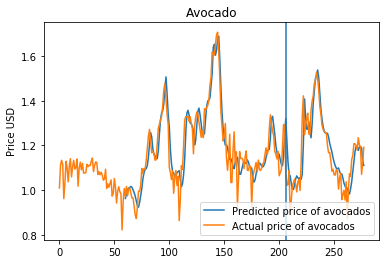

In [131]:
# we predict the price of avokados with the lstm
predicted_price_avocado = lstm.predict(X_test)


predicted_price_avocado = sc.inverse_transform(predicted_price_avocado.reshape(1, -1)).T


xc = np.arange(len(predicted_price_avocado))+nr
xc_2 = np.arange(len(data))



import matplotlib.pyplot as plt
plt.figure()
plt.plot(xc, predicted_price_avocado, label = 'Predicted price of avocados')
plt.plot(xc_2, data, label = 'Actual price of avocados')
plt.axvline(x=60+len(X_train))
plt.legend()
plt.title('Avocado')
plt.ylabel('Price USD')
plt.xlabel('The time steps')
plt.show()

In [14]:
def make_future_predictions(X_test,model,j):
    array = np.zeros((len(X_test)+j,60,1))
    array[0:-j] = X_test
    
    for r in range(j,0,-1):
        new_pred = model.predict(array[0:-r])[-1]
        array[-r][:-1] = array[-r-1][1:]
        array[-r][-1] = new_pred
    
    return model.predict(array)

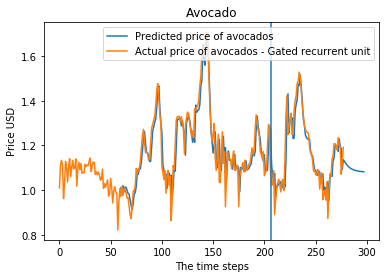

In [22]:
predicted_price_avocado = make_future_predictions(X_test,gru,20)


predicted_price_avocado = sc.inverse_transform(predicted_price_avocado.reshape(1, -1)).T


xc = np.arange(len(predicted_price_avocado))+nr
xc_2 = np.arange(len(data))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(xc, predicted_price_avocado, label = 'Predicted price of avocados')
plt.plot(xc_2, data, label = 'Actual price of avocados - Gated recurrent unit')
plt.axvline(x=60+len(X_train))
plt.legend()
plt.title('Avocado')
plt.ylabel('Price USD')
plt.xlabel('The time steps')
plt.show()

### R squared

In [54]:
p = 72
from sklearn.metrics import r2_score

r2_total = r2_score(data[60:], predicted_price_avocado[:218])
r2_val_test = r2_score(data[-p:], predicted_price_avocado[146:218])

print('R squared on total dataset: ',
      r2_total.round(2))
print('R squared on validation plus test: ',
      r2_val_test.round(2))

R squared on total dataset:  0.85
R squared on validation plus test:  0.82


### Prediction using mean volume sold

In [56]:
volume_test = conv_mean[:'2018'].iloc[:,1:2].values
volume_val = conv_mean['2018':].iloc[:,1:2].values
total_data = conv_mean.iloc[:,1:2].values
y_data = conv_mean.iloc[:,0:1].values

print('We use 278 time points and ', round(len(volume_test) / len(total_data),2), 'percent of the data for training')
nr_trainingpoints = len(volume_test)

scalar_volume = MinMaxScaler(feature_range=(0,1))
scalar_y = MinMaxScaler(feature_range=(0,1))

data_scaled = scalar_volume.fit_transform(total_data)
y_scaled = scalar_y.fit_transform(y_data)


# We use the 60 last points as x of t
nr = 60
X_train = []
y_train = []

X_test = []
y_test = []


for i in range(nr,len(total_data)):
    if (i < nr_trainingpoints):
        X_train.append(data_scaled[i-nr:i,0])
        y_train.append(y_scaled[i,0])
        
    X_test.append(data_scaled[i-nr:i,0])
    y_test.append(y_scaled[i,0])

    
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train),  np.array(X_test) , np.array(y_test)
 
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

We use 278 time points and  0.74 percent of the data for training


Best square error for the lstm model:  0.08552
Best square error for the gated model:  0.0163
Best square error for the Simple RNN:  0.05002
Best square error for the Convolutional LSTM:  0.04746


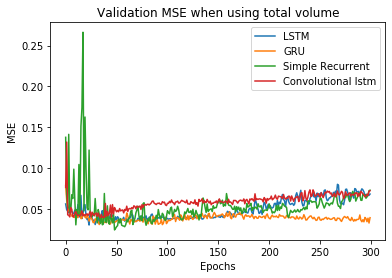

In [57]:
epochs = 300

lstm.compile(optimizer='adam',loss='mean_squared_error')
tot_lstm = lstm.fit(X_train,y_train, validation_data = (X_test,y_test,val_sample_weights), epochs=epochs, batch_size=32, verbose = 0)


gru.compile(optimizer='adam',loss='mean_squared_error')
tot_gru = gru.fit(X_train,y_train, validation_data = (X_test,y_test,val_sample_weights), epochs=epochs, batch_size=32, verbose = 0)


rnn.compile(optimizer='adam',loss='mean_squared_error')
tot_rnn = rnn.fit(X_train,y_train, validation_data = (X_test,y_test,val_sample_weights), epochs=epochs, batch_size=32, verbose = 0)


conv.compile(optimizer='adam',loss='mean_squared_error')
tot_conv = conv.fit(X_train,y_train, validation_data = (X_test,y_test,val_sample_weights), epochs=epochs, batch_size=32, verbose = 0)


lstm_volume = np.asarray(tot_lstm.history['val_loss'])*len(y_test)/val_samples
gru_volume = np.asarray(tot_gru.history['val_loss'])*len(y_test)/val_samples
rnn_volume = np.asarray(tot_rnn.history['val_loss'])*len(y_test)/val_samples
conv_volume = np.asarray(tot_conv.history['val_loss'])*len(y_test)/val_samples


lstm.compile(optimizer='adam',loss='mean_squared_error')
tot_lstm = lstm.fit(X_train, y_train, epochs=np.argmin(lstm_volume), batch_size=32, verbose = 0)

gru.compile(optimizer='adam',loss='mean_squared_error')
tot_gru = gru.fit(X_train, y_train, epochs=np.argmin(gru_volume), batch_size=32, verbose = 0)

rnn.compile(optimizer='adam',loss='mean_squared_error')
tot_rnn = rnn.fit(X_train,y_train, epochs=np.argmin(rnn_volume), batch_size=32, verbose = 0)

conv.compile(optimizer='adam',loss='mean_squared_error')
tot_conv = conv.fit(X_train,y_train, epochs=np.argmin(conv_volume), batch_size=32, verbose = 0)

error_lstm = lstm.evaluate(X_test,y_test,sample_weight = test_sample_weights, verbose = 0)*len(y_test)/test_samples
error_gru = gru.evaluate(X_test,y_test,sample_weight = test_sample_weights, verbose = 0)*len(y_test)/test_samples
error_rnn = rnn.evaluate(X_test,y_test,sample_weight = test_sample_weights, verbose = 0)*len(y_test)/test_samples
error_conv = conv.evaluate(X_test,y_test,sample_weight = test_sample_weights, verbose = 0)*len(y_test)/test_samples

print('Best square error for the lstm model: ', round(error_lstm,5))
print('Best square error for the gated model: ',round(error_gru,5))
print('Best square error for the Simple RNN: ', round(error_rnn,5))
print('Best square error for the Convolutional LSTM: ', round(error_conv,5))


import matplotlib.pyplot as plt
xc         = range(epochs)
plt.figure()

plt.plot(xc, lstm_volume, label = 'LSTM')
plt.plot(xc, gru_volume , label = 'GRU')
plt.plot(xc, rnn_volume, label = 'Simple Recurrent')
plt.plot(xc, conv_volume, label = 'Convolutional lstm')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Validation MSE when using total volume')
plt.show()

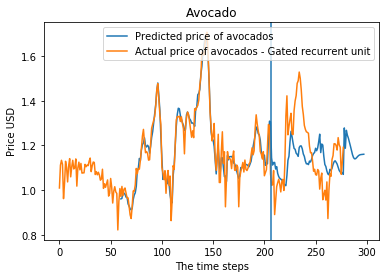

R squared on total dataset:  0.68
R squared on validation plus test:  0.05


In [58]:
predicted_price_avocado = make_future_predictions(X_test,gru,20)


predicted_price_avocado = sc.inverse_transform(predicted_price_avocado.reshape(1, -1)).T


xc = np.arange(len(predicted_price_avocado))+nr
xc_2 = np.arange(len(data))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(xc, predicted_price_avocado, label = 'Predicted price of avocados')
plt.plot(xc_2, data, label = 'Actual price of avocados - Gated recurrent unit')
plt.axvline(x=60+len(X_train))
plt.legend()
plt.title('Avocado')
plt.ylabel('Price USD')
plt.xlabel('The time steps')
plt.show()


from sklearn.metrics import r2_score

r2_total = r2_score(data[60:], predicted_price_avocado[:218])
r2_val_test = r2_score(data[-p:], predicted_price_avocado[146:218])

print('R squared on total dataset: ',
      r2_total.round(2))
print('R squared on validation plus test: ',
      r2_val_test.round(2))

### Prediction using both volume and previous prices

We use 278 time points and  0.74 percent of the data for training
Best square error for the lstm model:  0.01395
Best square error for the gated model:  0.00584
Best square error for the Simple RNN:  0.0062
Best square error for the Convolutional LSTM:  0.05454


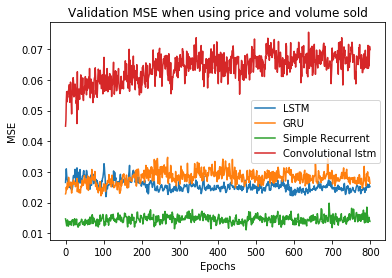

In [14]:
volume_test = conv_mean[:'2018'].iloc[:,1:2].values
volume_val = conv_mean['2018':].iloc[:,1:2].values
total_data = conv_mean.iloc[:,1:2].values
y_data = conv_mean.iloc[:,0:1].values

print('We use 278 time points and ', round(len(volume_test) / len(total_data),2), 'percent of the data for training')
nr_trainingpoints = len(volume_test)

scalar_volume = MinMaxScaler(feature_range=(0,1))
scalar_y = MinMaxScaler(feature_range=(0,1))

data_scaled = scalar_volume.fit_transform(total_data)
y_scaled = scalar_y.fit_transform(y_data)

# Data using both total volume and previous prices
nr = 30
X_train = []
y_train = []

X_test = []
y_test = []


for i in range(nr,len(total_data)):
    if (i < nr_trainingpoints):
        
        X_train.append(np.append(data_scaled[i-nr:i,0],y_scaled[i-nr:i,0]))
        y_train.append(y_scaled[i,0])
        
    X_test.append(np.append(data_scaled[i-nr:i,0],y_scaled[i-nr:i,0]))
    y_test.append(y_scaled[i,0])

    
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train),  np.array(X_test) , np.array(y_test)
 
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# Weight matrices
samples = int((len(y_test)-len(y_train))/2)
val_sample_weights = np.zeros(len(X_test))
for i in range(len(y_train),len(y_train)+samples):
    val_sample_weights[i] = 1

# Weight matrices
test_sample_weights = np.zeros(len(X_test))
for i in range(len(y_train)+samples,len(y_test)):
    test_sample_weights[i] = 1
    
epochs = 400

lstm.compile(optimizer='adam',loss='mean_squared_error')
tot_lstm = lstm.fit(X_train,y_train, validation_data = (X_test,y_test,val_sample_weights), epochs=epochs, batch_size=32, verbose = 0)


gru.compile(optimizer='adam',loss='mean_squared_error')
tot_gru = gru.fit(X_train,y_train, validation_data = (X_test,y_test,val_sample_weights), epochs=epochs, batch_size=32, verbose = 0)


rnn.compile(optimizer='adam',loss='mean_squared_error')
tot_rnn = rnn.fit(X_train,y_train, validation_data = (X_test,y_test,val_sample_weights), epochs=epochs, batch_size=32, verbose = 0)


conv.compile(optimizer='adam',loss='mean_squared_error')
tot_conv = conv.fit(X_train,y_train, validation_data = (X_test,y_test,val_sample_weights), epochs=epochs, batch_size=32, verbose = 0)


lstm_both = np.asarray(tot_lstm.history['val_loss'])*len(y_test)/samples
gru_both = np.asarray(tot_gru.history['val_loss'])*len(y_test)/samples
rnn_both = np.asarray(tot_rnn.history['val_loss'])*len(y_test)/samples
conv_both = np.asarray(tot_conv.history['val_loss'])*len(y_test)/samples



#Train for ideal amount
lstm.compile(optimizer='adam',loss='mean_squared_error')
tot_lstm = lstm.fit(X_train, y_train, epochs=np.argmin(lstm_both), batch_size=32, verbose = 0)

gru.compile(optimizer='adam',loss='mean_squared_error')
tot_gru = gru.fit(X_train, y_train, epochs=np.argmin(gru_both), batch_size=32, verbose = 0)

rnn.compile(optimizer='adam',loss='mean_squared_error')
tot_rnn = rnn.fit(X_train,y_train, epochs=np.argmin(rnn_both), batch_size=32, verbose = 0)

conv.compile(optimizer='adam',loss='mean_squared_error')
tot_conv = conv.fit(X_train,y_train, epochs=np.argmin(conv_both), batch_size=32, verbose = 0)



#Evaluate
error_lstm = lstm.evaluate(X_test,y_test,sample_weight = test_sample_weights, verbose = 0)*len(y_test)/samples
error_gru = gru.evaluate(X_test,y_test,sample_weight = test_sample_weights, verbose = 0)*len(y_test)/samples
error_rnn = rnn.evaluate(X_test,y_test,sample_weight = test_sample_weights, verbose = 0)*len(y_test)/samples
error_conv = conv.evaluate(X_test,y_test,sample_weight = test_sample_weights, verbose = 0)*len(y_test)/samples


print('Best square error for the lstm model: ', round(error_lstm,5))
print('Best square error for the gated model: ',round(error_gru,5))
print('Best square error for the Simple RNN: ', round(error_rnn,5))
print('Best square error for the Convolutional LSTM: ', round(error_conv,5))


import matplotlib.pyplot as plt
xc         = range(epochs)
plt.figure()

plt.plot(xc, lstm_both, label = 'LSTM')
plt.plot(xc, gru_both , label = 'GRU')
plt.plot(xc, rnn_both, label = 'Simple Recurrent')
plt.plot(xc, conv_both, label = 'Convolutional lstm')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Validation MSE when using price and volume sold')
plt.show()

In [61]:
total_data = conv_mean.iloc[:,1:2].values
y_data = conv_mean.iloc[:,0:1].values

r = np.corrcoef(y_data.reshape([278]),total_data.reshape([278]))
print('Correlation' , r[1][0])

Correlation -0.42011497852604995


### A test to see the reason why amount + total volume dosn't outperform amount only

In [64]:
volume_test = conv_mean[:'2018'].iloc[:,1:2].values
volume_val = conv_mean['2018':].iloc[:,1:2].values
total_data = conv_mean.iloc[:,1:2].values
y_data = conv_mean.iloc[:,0:1].values

nr_trainingpoints = len(volume_test)

scalar_volume = MinMaxScaler(feature_range=(0,1))
scalar_y = MinMaxScaler(feature_range=(0,1))

data_scaled = scalar_volume.fit_transform(total_data)
y_scaled = scalar_y.fit_transform(y_data)

# Data using both total volume and previous prices
nr = 60
X_train = []
y_train = []

X_test = []
y_test = []


for i in range(nr,len(total_data)):
    if (i < nr_trainingpoints):
        
        X_train.append(np.append(data_scaled[i-nr:i,0],y_scaled[i-nr:i,0]))
        y_train.append(y_scaled[i,0])
        
    X_test.append(np.append(data_scaled[i-nr:i,0],y_scaled[i-nr:i,0]))
    y_test.append(y_scaled[i,0])

    
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train),  np.array(X_test) , np.array(y_test)
 
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# Weight matrices
samples = int((len(y_test)-len(y_train))/2)
val_sample_weights = np.zeros(len(X_test))
for i in range(len(y_train),len(y_train)+samples):
    val_sample_weights[i] = 1

# Weight matrices
test_sample_weights = np.zeros(len(X_test))
for i in range(len(y_train)+samples,len(y_test)):
    test_sample_weights[i] = 1
    


epochs_gru = 1000
units = 50
dropout = 0.2

gru = Sequential()

# First
gru.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1],1)))
gru.add(Dropout(dropout))

# Second
gru.add(GRU(units=units, return_sequences=True))
gru.add(Dropout(dropout))

# Third
gru.add(GRU(units=units, return_sequences=True))
gru.add(Dropout(dropout))

# Fourth 
gru.add(GRU(units=units))
gru.add(Dropout(dropout))

# Output - regresstion has one output unit
gru.add(Dense(units=1))

# Use default optimization values
gru.compile(optimizer='rmsprop',loss='mean_squared_error')
new = gru.fit(X_train,y_train, validation_data = (X_test,y_test,val_sample_weights), epochs=epochs_gru, batch_size=32, verbose = 0)


new_2 = np.asarray(new.history['val_loss'])*len(y_test)/samples


gru.compile(optimizer='adam',loss='mean_squared_error')
tot_gru = gru.fit(X_train, y_train, epochs=np.argmin(new), batch_size=32, verbose = 0)


error_gru = gru.evaluate(X_test,y_test,sample_weight = test_sample_weights, verbose = 0)*len(y_test)/samples
val_error_gru = gru.evaluate(X_test,y_test,sample_weight = val_sample_weights, verbose = 0)*len(y_test)/samples

print('Best val error for the lstm model: ', round(val_error_gru,5))
print('Best square error for the gated model: ',round(error_gru,5))



Best val error for the lstm model:  0.01873
Best square error for the gated model:  0.00688


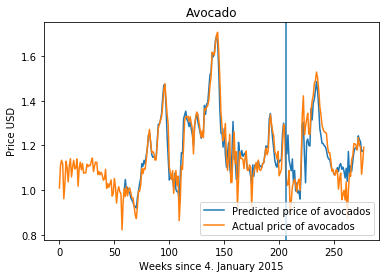

In [66]:
# we predict the price of avokados with the lstm
predicted_price_avocado = gru.predict(X_test)


predicted_price_avocado = sc.inverse_transform(predicted_price_avocado.reshape(1, -1)).T


xc = np.arange(len(predicted_price_avocado))+nr-1#
xc_2 = np.arange(len(data))


plt.figure()
plt.plot(xc, predicted_price_avocado, label = 'Predicted price of avocados')
plt.plot(xc_2, data, label = 'Actual price of avocados')
plt.axvline(x=60+len(X_train))
plt.legend()
plt.title('Avocado')
plt.ylabel('Price USD')
plt.xlabel('Weeks since 4. January 2015')
plt.show()